# Part 1: Pong Tournament
## **DQN and REINFORCE implementation on Pong environment**

In [1]:
!pip install gymnasium[atari]
!pip install gymnasium[accept-rom-license]
!pip install ale-py
!pip install autorom
!AutoROM --accept-license

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 28.0 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: shimmy
    Found existing installation: Shimmy 1.3.0
    Uninstalling Shimmy-1.3.0:
      Successfully uninstalled Shimmy-1.3.0
  Attempting uninstall: ale-py
    Found existing installation: ale-py 0.11.2
    Uninstalling ale-py-0.11.2:
      Successfully uninstalled ale-py-0.11.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kaggle-environments 1.18.0 requires shimmy>=1.2.1, but you have shimmy 0.2.1 which is incompatible.
dopamine-rl 4.1.2 requires ale-py>=0.10.1, but you have ale-py 0.8.1 which is incompatible.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 12.0 MB/s eta 0:00:0000:01
  Installing build dependencies ... done
  Getting requi

Import necessary libraries

In [2]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import collections
import random
import time
import datetime
from collections import deque, namedtuple
import matplotlib.pyplot as plt
import cv2
import os
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
print(f"Using Gymnasium version: {gym.__version__}")
print(f"Using PyTorch version: {torch.__version__}")

# Define the Experience tuple
Experience = namedtuple('Experience', field_names=['state', 'action', 'reward', 'new_state', 'done'])

Using device: cuda
Using Gymnasium version: 0.29.0
Using PyTorch version: 2.6.0+cu124


## Data preprocessing (Wrappers)
We need to apply the same set of wrappers used during the model's training phase to ensure that the inputs to the model are consistent in shape, format, and meaning.

In [4]:
# Fixed Environment Wrappers for Gymnasium
class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        # Check if fire action is available - handle different environments gracefully
        action_meanings = env.unwrapped.get_action_meanings()
        if len(action_meanings) > 1:
            self._has_fire_action = action_meanings[1] == 'FIRE'
        else:
            self._has_fire_action = False

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        if self._has_fire_action:
            obs, _, terminated, truncated, _ = self.env.step(1)
            if terminated or truncated:
                obs, info = self.env.reset(**kwargs)
            obs, _, terminated, truncated, _ = self.env.step(2)
            if terminated or truncated:
                obs, info = self.env.reset(**kwargs)
        return obs, info

    def step(self, action):
        return self.env.step(action)

class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        super().__init__(env)
        self._obs_buffer = collections.deque(maxlen=2)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        terminated = False
        truncated = False
        info = {}
        
        for _ in range(self._skip):
            obs, reward, terminated, truncated, info = self.env.step(action)
            self._obs_buffer.append(obs)
            total_reward += reward
            if terminated or truncated:
                break
        
        max_frame = np.max(np.stack(self._obs_buffer), axis=0)
        return max_frame, total_reward, terminated, truncated, info

    def reset(self, **kwargs):
        self._obs_buffer.clear()
        obs, info = self.env.reset(**kwargs)
        self._obs_buffer.append(obs)
        return obs, info

class ProcessFrame84(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(84, 84, 1), dtype=np.uint8)

    def observation(self, obs):
        return self._process_frame(obs)

    def _process_frame(self, frame):
        if frame.size == 210 * 160 * 3:
            img = np.reshape(frame, [210, 160, 3]).astype(np.float32)
        elif frame.size == 250 * 160 * 3:
            img = np.reshape(frame, [250, 160, 3]).astype(np.float32)
        else:
            # Try to handle different frame sizes
            img = frame.astype(np.float32)
            if len(img.shape) == 3 and img.shape[2] == 3:
                pass  # Already in correct format
            else:
                # Assume standard Atari frame shape
                try:
                    img = img.reshape((210, 160, 3))
                except:
                    # If reshaping fails, use as is and hope for the best
                    pass
        
        # Convert to grayscale
        img = img[:, :, 0] * 0.299 + img[:, :, 1] * 0.587 + img[:, :, 2] * 0.114
        
        # Resize
        resized_screen = cv2.resize(img, (84, 110), interpolation=cv2.INTER_AREA)
        x_t = resized_screen[18:102, :]
        x_t = np.reshape(x_t, [84, 84, 1])
        return x_t.astype(np.uint8)

class BufferWrapper(gym.ObservationWrapper):
    def __init__(self, env, n_steps):
        super().__init__(env)
        self.n_steps = n_steps
        old_space = env.observation_space
        
        # Fix: Properly handle the observation space dimensions
        new_shape = (old_space.shape[0], old_space.shape[1], old_space.shape[2] * n_steps)

        self.observation_space = gym.spaces.Box(
            low=0.0, high=1.0,
            shape=new_shape,
            dtype=np.float32
        )

        self.buffer = deque(maxlen=n_steps)

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        for _ in range(self.n_steps):
            self.buffer.append(obs)
        return self._get_obs(), info

    def observation(self, obs):
        self.buffer.append(obs)
        return self._get_obs()

    def _get_obs(self):
        # Stack along channel axis (axis=2 for HWC format)
        return np.concatenate(list(self.buffer), axis=2) 

class ImageToPyTorch(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        old_shape = self.observation_space.shape
        # Fix: Change from HWC to CHW format
        self.observation_space = gym.spaces.Box(
            low=0.0, high=1.0, shape=(old_shape[2], old_shape[0], old_shape[1]), dtype=np.float32
        )

    def observation(self, obs):
        # Fix: Properly transpose from HWC to CHW
        return np.transpose(obs, (2, 0, 1))

class ScaledFloatFrame(gym.ObservationWrapper):
    def observation(self, obs):
        return np.array(obs, dtype=np.float32) / 255.0


# Create environment function
def make_env(env_name):
    env = gym.make(env_name, render_mode='rgb_array')
    env = MaxAndSkipEnv(env)
    env = FireResetEnv(env)
    env = ProcessFrame84(env)
    env = ImageToPyTorch(env)
    env = BufferWrapper(env, 4)
    env = ScaledFloatFrame(env)
    return env

## Test the environment wrappers

In [5]:
ENV_NAME = "PongNoFrameskip-v4"
test_env = make_env(ENV_NAME)

# Print environment info
print("*** Test Environment ***")
print(f"Observation space shape: {test_env.observation_space.shape}")
print(f"Observation space type: {test_env.observation_space.dtype}")
print(f"Action space: {test_env.action_space}")
print(f"Number of actions: {test_env.action_space.n}")

# Test reset
obs, info = test_env.reset()
print(f"\nInitial observation shape: {obs.shape}")
print(f"Initial observation range: [{obs.min()}, {obs.max()}]")

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


*** Test Environment ***
Observation space shape: (1, 84, 336)
Observation space type: float32
Action space: Discrete(6)
Number of actions: 6

Initial observation shape: (1, 84, 336)
Initial observation range: [0.34117648005485535, 0.6352941393852234]


# **DQN**

In [6]:
# DQN Network
class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )

        # Calculate the size of the flattened features
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)
            conv_out = self.conv(dummy_input)
            n_flatten = conv_out.view(1, -1).size(1)

        self.fc = nn.Sequential(
            nn.Linear(n_flatten, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def forward(self, x):
        # x shape: [batch_size, channels, height, width]
        conv_out = self.conv(x)
        flattened = conv_out.view(conv_out.size(0), -1)
        return self.fc(flattened)

# Test the network
test_net = DQN(test_env.observation_space.shape, test_env.action_space.n).to(device)
print(f"Network architecture: {test_net}")
print(f"Number of parameters: {sum(p.numel() for p in test_net.parameters())}")

Network architecture: DQN(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=17024, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=6, bias=True)
  )
)
Number of parameters: 8791718


In [7]:
# Experience Buffer
class ExperienceBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, next_states, dones = zip(*[self.buffer[i] for i in indices])

        return (
            np.array(states, dtype=np.float32),
            np.array(actions, dtype=np.int64),
            np.array(rewards, dtype=np.float32),
            np.array(next_states, dtype=np.float32),
            np.array(dones, dtype=np.bool_)
        )

# Agent
class Agent:
    def __init__(self, env, exp_buffer):
        self.env = env
        self.exp_buffer = exp_buffer
        self.reset()

    def reset(self):
        self.state, _ = self.env.reset()
        self.total_reward = 0.0

    @torch.no_grad()
    def play_step(self, net, epsilon, device="cpu"):
        done_reward = None
    
        if np.random.random() < epsilon:
            action = self.env.action_space.sample()
        else:
            state_v = torch.tensor(np.array([self.state], copy=False), dtype=torch.float32).to(device)
            q_vals = net(state_v)
            _, act_v = torch.max(q_vals, dim=1)
            action = int(act_v.item())
    
        new_state, reward, terminated, truncated, _ = self.env.step(action)
        done = terminated or truncated
    
        exp = Experience(self.state, action, reward, new_state, done)
        self.exp_buffer.append(exp)
    
        self.state = new_state
        self.total_reward += reward
    
        if done:
            done_reward = self.total_reward
            self.reset()
    
        return done_reward

In [8]:
# Loss calculation functions
def calc_loss(batch, net, tgt_net, device, gamma):
    states, actions, rewards, next_states, dones = batch

    states_v = torch.tensor(states, dtype=torch.float32).to(device)
    next_states_v = torch.tensor(next_states, dtype=torch.float32).to(device)
    actions_v = torch.tensor(actions, dtype=torch.int64).to(device)
    rewards_v = torch.tensor(rewards, dtype=torch.float32).to(device)
    done_mask = torch.tensor(dones, dtype=torch.bool).to(device)

    state_action_values = net(states_v).gather(1, actions_v.unsqueeze(-1)).squeeze(-1)

    with torch.no_grad():
        next_state_values = tgt_net(next_states_v).max(1)[0]
        next_state_values[done_mask] = 0.0
        expected_state_action_values = rewards_v + gamma * next_state_values

    return nn.MSELoss()(state_action_values, expected_state_action_values)

# Plotting function
def plot_rewards(rewards, ma_window=100):
    plt.figure(figsize=(12, 8))
    plt.title("Training Rewards")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    
    if len(rewards) > 0:
        plt.plot(rewards, alpha=0.3, label='Raw rewards', color='blue')
        
        if len(rewards) >= ma_window:
            ma_rewards = []
            for i in range(len(rewards) - ma_window + 1):
                ma_rewards.append(np.mean(rewards[i:i+ma_window]))
            plt.plot(range(ma_window-1, len(rewards)), ma_rewards, 
                    label=f'Moving Average ({ma_window} episodes)', color='red', linewidth=2)
        
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

## Training

In [9]:
# Training function
def train_dqn():
    # Create models directory
    os.makedirs("models", exist_ok=True)
    
    # Parameters
    ENV_NAME = "PongNoFrameskip-v4"
    MEAN_REWARD_BOUND = 18.0  # Pong is solved when average reward > 18
    
    GAMMA = 0.99
    BATCH_SIZE = 32
    REPLAY_SIZE = 10000
    LEARNING_RATE = 1e-4
    SYNC_TARGET_FRAMES = 1000  # Reduced for faster updates
    REPLAY_START_SIZE = 10000  # Increased for more initial experiences
    
    EPSILON_DECAY_LAST_FRAME = 100000
    EPSILON_START = 1.0
    EPSILON_FINAL = 0.02
    
    print(f"Training DQN on {ENV_NAME}")
    print(f"Device: {device}")
    
    # Create environment
    env = make_env(ENV_NAME)

    # Initialize networks
    net = DQN(env.observation_space.shape, env.action_space.n).to(device)
    tgt_net = DQN(env.observation_space.shape, env.action_space.n).to(device)
    tgt_net.load_state_dict(net.state_dict())
    
    print(f"Network: {net}")
    print(f"Input shape: {env.observation_space.shape}")
    print(f"Number of actions: {env.action_space.n}")
    
    # Initialize buffer and agent
    buffer = ExperienceBuffer(REPLAY_SIZE)
    agent = Agent(env, buffer)
    
    optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
    total_rewards = []
    frame_idx = 0
    ts_frame = 0
    ts = time.time()
    best_mean_reward = None
    
    print("Starting training at:", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    print("Filling replay buffer...")
    
    # Initial filling of replay buffer
    while len(buffer) < REPLAY_START_SIZE:
        frame_idx += 1
        epsilon = 1.0  # Always explore during initial filling
        reward = agent.play_step(net, epsilon, device)
        if reward is not None:
            total_rewards.append(reward)
            
        if frame_idx % 1000 == 0:
            print(f"Filled {len(buffer)}/{REPLAY_START_SIZE} experiences in replay buffer")
    
    print("Replay buffer filled. Starting training...")
    
    episode_count = 0
    
    max_frames = 450000
    
    while frame_idx < max_frames:
        frame_idx += 1
        
        # Calculate epsilon
        epsilon = max(EPSILON_FINAL, 
                     EPSILON_START - (EPSILON_START - EPSILON_FINAL) * frame_idx / EPSILON_DECAY_LAST_FRAME)
        
        reward = agent.play_step(net, epsilon, device)
        if reward is not None:
            total_rewards.append(reward)
            episode_count += 1
            
            # Calculate mean reward over last 100 episodes
            mean_reward = np.mean(total_rewards[-100:]) if len(total_rewards) >= 100 else np.mean(total_rewards)
            
            # Calculate speed
            speed = (frame_idx - ts_frame) / (time.time() - ts)
            ts_frame = frame_idx
            ts = time.time()
            
            # Print progress every 10 episodes
            if episode_count % 10 == 0:
                print(f"Episode {episode_count}, Frame {frame_idx}, Reward: {reward:.1f}, "
                      f"Mean Reward (last 100): {mean_reward:.3f}, Epsilon: {epsilon:.3f}, Speed: {speed:.2f} f/s")
            
            # Save best model
            if best_mean_reward is None or mean_reward > best_mean_reward:
                if best_mean_reward is not None:
                    print(f"New best mean reward: {best_mean_reward:.3f} -> {mean_reward:.3f}")
                best_mean_reward = mean_reward
                model_path = f"models/{ENV_NAME}_best_{mean_reward:.2f}.pth"
                torch.save(net.state_dict(), model_path)
                print(f"Model saved to {model_path}")
            
            # Check if solved
            if mean_reward >= MEAN_REWARD_BOUND:
                print(f"Solved at frame {frame_idx} with mean reward {mean_reward:.3f}!")
                break
        
        # Sync target network
        if frame_idx % SYNC_TARGET_FRAMES == 0:
            tgt_net.load_state_dict(net.state_dict())
            print(f"Target network updated at frame {frame_idx}")
        
        # Training step - only train if we have enough samples
        if len(buffer) >= BATCH_SIZE:
            optimizer.zero_grad()
            batch = buffer.sample(BATCH_SIZE)
            loss_t = calc_loss(batch, net, tgt_net, device, GAMMA)
            loss_t.backward()
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
            optimizer.step()
            
    print("Training completed at:", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    print(f"Trained for {frame_idx} frames, {episode_count} episodes")
    
    # Save final model
    final_model_path = f"models/{ENV_NAME}_final.pth"
    torch.save(net.state_dict(), final_model_path)
    print(f"Final model saved to {final_model_path}")
    
    return total_rewards, net

In [10]:
# Start the training
print("=" * 60)
print("STARTING DQN TRAINING ON PONG")
print("=" * 60)

rewards, trained_net = train_dqn()

print("=" * 60)
print("TRAINING COMPLETED")
print("=" * 60)

STARTING DQN TRAINING ON PONG
Training DQN on PongNoFrameskip-v4
Device: cuda
Network: DQN(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=17024, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=6, bias=True)
  )
)
Input shape: (1, 84, 336)
Number of actions: 6
Starting training at: 2025-12-02 14:08:30
Filling replay buffer...
Filled 1000/10000 experiences in replay buffer
Filled 2000/10000 experiences in replay buffer
Filled 3000/10000 experiences in replay buffer
Filled 4000/10000 experiences in replay buffer
Filled 5000/10000 experiences in replay buffer
Filled 6000/10000 experiences in replay buffer
Filled 7000/10000 experiences in replay buffer
Filled 8000/10000 experiences in replay buffer
Fi

## Final Plot

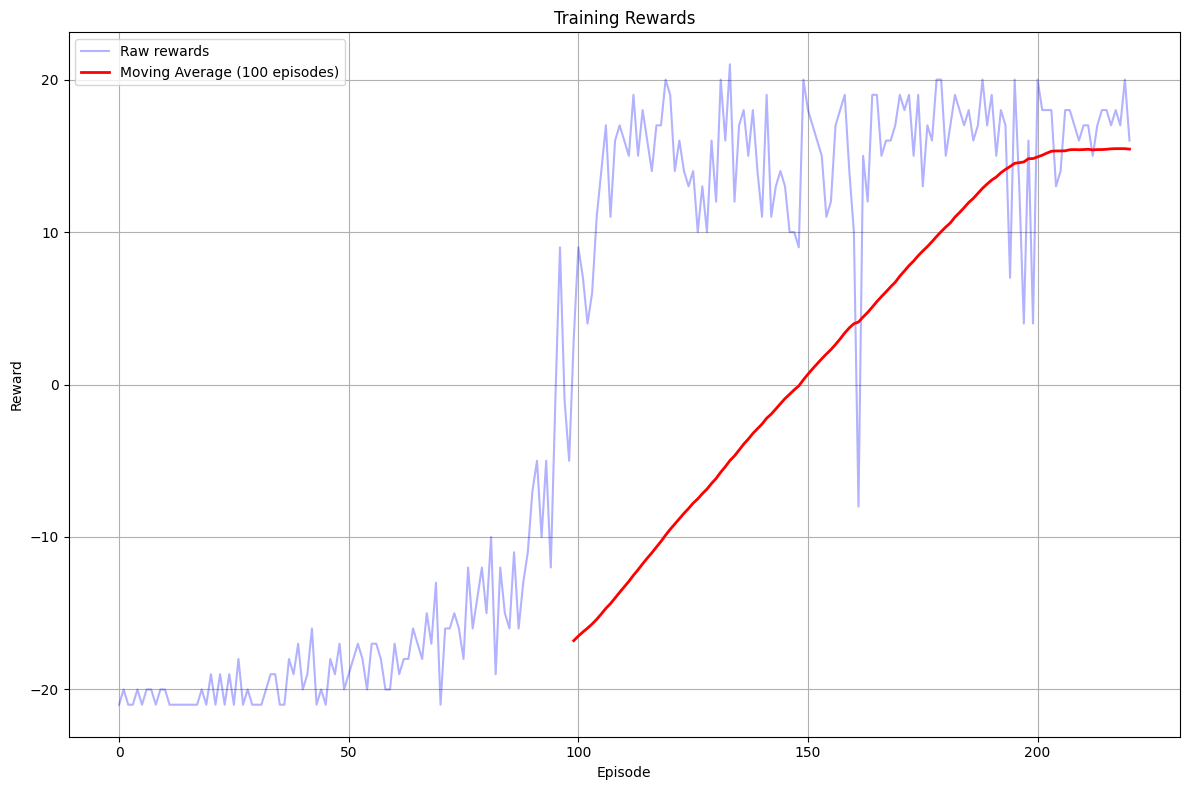

Total episodes trained: 221
Best reward achieved: 21.0
Mean reward of last 100 episodes: 15.44


In [11]:
# Plot final results
if rewards:
    plot_rewards(rewards, ma_window=100)
    print(f"Total episodes trained: {len(rewards)}")
    print(f"Best reward achieved: {max(rewards) if rewards else 0}")
    print(f"Mean reward of last 100 episodes: {np.mean(rewards[-100:]) if len(rewards) >= 100 else np.mean(rewards)}")

# **REINFORCE**
For REINFORCE, we need a policy network that outputs action probabilities.

In [ ]:
class PolicyNetwork(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(PolicyNetwork, self).__init__()
        
        # CNN feature extractor
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )
        
        # Calculate the size of the flattened features
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)
            conv_out = self.conv(dummy_input)
            n_flatten = conv_out.view(1, -1).size(1)
        
        # Policy head
        self.policy_head = nn.Sequential(
            nn.Linear(n_flatten, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions),
            nn.Softmax(dim=-1)
        )
        
        # Value head (for baseline, optional for REINFORCE with baseline)
        self.value_head = nn.Sequential(
            nn.Linear(n_flatten, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )
        
    def forward(self, x):
        # x shape: [batch_size, channels, height, width]
        conv_out = self.conv(x)
        flattened = conv_out.view(conv_out.size(0), -1)
        
        action_probs = self.policy_head(flattened)
        state_value = self.value_head(flattened)
        
        return action_probs, state_value
    
    def get_action(self, state, device="cpu"):
        """Sample an action from the policy"""
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        action_probs, _ = self.forward(state_tensor)
        action_probs = action_probs.detach().cpu().numpy()[0]
        
        # Sample action from probability distribution
        action = np.random.choice(len(action_probs), p=action_probs)
        return action, action_probs[action]

# Test the network
policy_net = PolicyNetwork(test_env.observation_space.shape, test_env.action_space.n).to(device)
print(f"Policy Network architecture: {policy_net}")
print(f"Number of parameters: {sum(p.numel() for p in policy_net.parameters()):,}")

In [ ]:
class REINFORCEAgent:
    def __init__(self, env, policy_net, device="cpu"):
        self.env = env
        self.policy_net = policy_net
        self.device = device
        self.reset()
        
    def reset(self):
        self.state, _ = self.env.reset()
        self.total_reward = 0.0
        self.trajectory = []
        
    def play_step(self, render=False):
        """Play one step and store the transition"""
        # Get action from policy
        action, action_prob = self.policy_net.get_action(self.state, self.device)
        
        # Take action
        new_state, reward, terminated, truncated, _ = self.env.step(action)
        done = terminated or truncated
        
        # Store transition
        self.trajectory.append({
            'state': self.state.copy(),
            'action': action,
            'action_prob': action_prob,
            'reward': reward,
            'done': done
        })
        
        self.state = new_state
        self.total_reward += reward
        
        return done
        
    def play_episode(self, max_steps=1000, render=False):
        """Play a complete episode"""
        self.reset()
        
        for step in range(max_steps):
            done = self.play_step(render)
            if done:
                break
                
        return self.total_reward, self.trajectory

## Training

In [ ]:
def compute_returns(rewards, gamma=0.99):
    """Compute discounted returns from the end of episode"""
    returns = []
    R = 0
    
    # Compute returns from the end
    for r in reversed(rewards):
        R = r + gamma * R
        returns.insert(0, R)
    
    return returns

def normalize_returns(returns):
    """Normalize returns to have zero mean and unit variance"""
    returns = np.array(returns)
    returns = (returns - returns.mean()) / (returns.std() + 1e-8)
    return returns

def train_reinforce():
    # Create models directory
    os.makedirs("models", exist_ok=True)
    
    # Hyperparameters
    ENV_NAME = "PongNoFrameskip-v4"
    GAMMA = 0.99
    LEARNING_RATE = 3e-4
    MAX_EPISODES = 5000
    MAX_STEPS_PER_EPISODE = 10000
    SOLVED_THRESHOLD = 18.0  # Pong is solved when average reward > 18
    
    print(f"Training REINFORCE on {ENV_NAME}")
    print(f"Device: {device}")
    
    # Create environment
    env = make_env(ENV_NAME)
    
    # Initialize policy network
    policy_net = PolicyNetwork(env.observation_space.shape, env.action_space.n).to(device)
    
    # Optimizer
    optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)
    
    # Agent
    agent = REINFORCEAgent(env, policy_net, device)
    
    # Training metrics
    all_rewards = []
    episode_lengths = []
    best_mean_reward = -float('inf')
    
    print("Starting training at:", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    
    for episode in range(MAX_EPISODES):
        # Play one episode
        episode_reward, trajectory = agent.play_episode(MAX_STEPS_PER_EPISODE)
        all_rewards.append(episode_reward)
        episode_lengths.append(len(trajectory))
        
        # Extract components from trajectory
        states = [t['state'] for t in trajectory]
        actions = [t['action'] for t in trajectory]
        action_probs = [t['action_prob'] for t in trajectory]
        rewards = [t['reward'] for t in trajectory]
        
        # Compute returns
        returns = compute_returns(rewards, GAMMA)
        returns = normalize_returns(returns)
        
        # Convert to tensors
        states_tensor = torch.FloatTensor(np.array(states)).to(device)
        actions_tensor = torch.LongTensor(actions).to(device)
        returns_tensor = torch.FloatTensor(returns).to(device)
        
        # Get current action probabilities
        current_action_probs, _ = policy_net(states_tensor)
        selected_action_probs = current_action_probs.gather(1, actions_tensor.unsqueeze(1)).squeeze()
        
        # Compute loss (negative log likelihood weighted by returns)
        loss = -torch.mean(torch.log(selected_action_probs) * returns_tensor)
        
        # Optimize
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 1.0)
        optimizer.step()
        
        # Log progress
        if (episode + 1) % 10 == 0:
            mean_reward = np.mean(all_rewards[-10:]) if len(all_rewards) >= 10 else np.mean(all_rewards)
            print(f"Episode {episode + 1}: Reward = {episode_reward:.1f}, "
                  f"Mean Reward (last 10) = {mean_reward:.3f}, "
                  f"Loss = {loss.item():.4f}")
            
            # Save best model
            if mean_reward > best_mean_reward:
                best_mean_reward = mean_reward
                model_path = f"models/{ENV_NAME}_reinforce_best_{mean_reward:.2f}.pth"
                torch.save(policy_net.state_dict(), model_path)
                print(f"  New best model saved to {model_path}")
        
        # Check if solved
        if len(all_rewards) >= 100:
            recent_mean_reward = np.mean(all_rewards[-100:])
            if recent_mean_reward >= SOLVED_THRESHOLD:
                print(f"\nEnvironment solved at episode {episode + 1}!")
                print(f"Average reward over last 100 episodes: {recent_mean_reward:.2f}")
                break
    
    print("\nTraining completed at:", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    print(f"Trained for {len(all_rewards)} episodes")
    
    # Save final model
    final_model_path = f"models/{ENV_NAME}_reinforce_final.pth"
    torch.save(policy_net.state_dict(), final_model_path)
    print(f"Final model saved to {final_model_path}")
    
    return all_rewards, episode_lengths, policy_net

In [ ]:
def plot_training_results(rewards, episode_lengths, window_size=100):
    """Plot training results"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot rewards
    ax1.set_title("Training Rewards")
    ax1.set_xlabel("Episode")
    ax1.set_ylabel("Reward")
    ax1.plot(rewards, alpha=0.3, color='blue', label='Episode Reward')
    
    if len(rewards) >= window_size:
        # Moving average
        ma_rewards = []
        for i in range(len(rewards) - window_size + 1):
            ma_rewards.append(np.mean(rewards[i:i+window_size]))
        ax1.plot(range(window_size-1, len(rewards)), ma_rewards, 
                color='red', linewidth=2, label=f'{window_size}-episode Moving Average')
    
    ax1.legend()
    ax1.grid(True)
    
    # Plot episode lengths
    ax2.set_title("Episode Lengths")
    ax2.set_xlabel("Episode")
    ax2.set_ylabel("Steps")
    ax2.plot(episode_lengths, alpha=0.3, color='green', label='Episode Length')
    
    if len(episode_lengths) >= window_size:
        # Moving average
        ma_lengths = []
        for i in range(len(episode_lengths) - window_size + 1):
            ma_lengths.append(np.mean(episode_lengths[i:i+window_size]))
        ax2.plot(range(window_size-1, len(episode_lengths)), ma_lengths, 
                color='orange', linewidth=2, label=f'{window_size}-episode Moving Average')
    
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

def test_agent(env, policy_net, num_episodes=10, render=False):
    """Test the trained agent"""
    policy_net.eval()
    test_rewards = []
    
    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        done = False
        step = 0
        
        while not done and step < 10000:
            if render:
                env.render()
            
            # Get action from policy
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                action_probs, _ = policy_net(state_tensor)
                action = torch.argmax(action_probs).item()
            
            # Take action
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode_reward += reward
            step += 1
        
        test_rewards.append(episode_reward)
        print(f"Test Episode {episode + 1}: Reward = {episode_reward:.1f}")
    
    env.close()
    
    print(f"\nAverage test reward over {num_episodes} episodes: {np.mean(test_rewards):.2f}")
    print(f"Min reward: {np.min(test_rewards):.2f}")
    print(f"Max reward: {np.max(test_rewards):.2f}")
    
    return test_rewards

In [ ]:
# Start the training
print("=" * 60)
print("STARTING REINFORCE TRAINING ON PONG")
print("=" * 60)

rewards, lengths, trained_policy_net = train_reinforce()

print("=" * 60)
print("TRAINING COMPLETED")
print("=" * 60)

In [ ]:
# Plot training results
plot_training_results(rewards, lengths, window_size=100)

# Show final statistics
if rewards:
    print(f"Final Statistics:")
    print(f"Total episodes trained: {len(rewards)}")
    print(f"Best episode reward: {max(rewards):.2f}")
    print(f"Average reward of last 100 episodes: {np.mean(rewards[-100:]):.2f}" 
          if len(rewards) >= 100 else f"Average reward: {np.mean(rewards):.2f}")

In [ ]:
# Create test environment
test_env = make_env(ENV_NAME, render_mode='human')

# Load best model (if you want to test with a specific model)
# trained_policy_net.load_state_dict(torch.load("models/PongNoFrameskip-v4_reinforce_best_X.XX.pth"))

# Test the agent
print("\nTesting trained agent...")
test_rewards = test_agent(test_env, trained_policy_net, num_episodes=5, render=True)